In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [20]:
import math
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [7]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [8]:
sm = stepmodel.read_json(input_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')
z = stepmodel.read_json(model_path + 'de_zones')

In [9]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = ae.centroids
sm.zones = z.zones

In [10]:
len(sm.zone_to_road.loc[sm.zone_to_road['a'].str.startswith('DE'), 'a'].unique())

2217

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

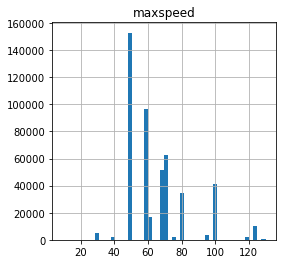

In [11]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [12]:
sm.road_links['maxspeed'].unique()

array([ 81.        ,  76.        ,  70.        ,  60.        ,
       125.        , 100.        ,  68.        ,  58.        ,
        80.        ,  50.        , 120.        ,  40.        ,
        96.        ,  30.        , 130.        ,  90.        ,
        10.        ,  20.        ,  65.        ,   9.16666667])

Now, generate travel time based on the information available. In many transport models, time depends on the network flow. As a simplification for this long-term strategic model in times of modern traffic management, we assume speed limits to be equilibrated with the traffic situation. Hence, travel time depends on speed limits.

In a [publication by the Federal Environmental Agency](https://www.umweltbundesamt.de/publikationen/klimaschutz-durch-tempolimit), the following average speeds were found on the respective road sections:
- Speed limit | average traffic flow speed 
- <=60 | 60
- 80 | 87.4
- 100 | 103.3
- 120 | 115.6
- 130 | 118.3
- open | 124.7

The following calculations approximate these figures.

In [15]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits

# For up to 60km/h average speed equals the speed limit
mask60 = sm.road_links['maxspeed']<=60
sm.road_links.loc[mask60, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

# Then, up to under 100km/h, average speeds are 10% above the speed limit
mask100 = sm.road_links['maxspeed']<100
sm.road_links.loc[(~mask60)&(mask100), 'time'] = \
    sm.road_links['length'] / 1000 / sm.road_links['maxspeed'] * 3600 * 1.1

# Then, speed follows a polynomial of y = -0,0115x2 + 3,145x - 96,2 (R^2=1)
mask_not_open = sm.road_links['maxspeed']!=125
sm.road_links.loc[(~mask100)&(mask_not_open), 'time'] = sm.road_links['length'] / 1000 / \
    (-0.0115*np.power(sm.road_links['maxspeed'], 2) + 3.145*sm.road_links['maxspeed'] - 96.2) * 3600

# without speed limit
sm.road_links.loc[~mask_not_open, 'time'] = sm.road_links['length'] / 1000 \
    / sm.road_links['maxspeed'] * 3600

assert len(sm.road_links[sm.road_links['time'].isna()])==0
sm.road_links.loc[sm.road_links['time']==0, 'time'] = 1

<AxesSubplot:>

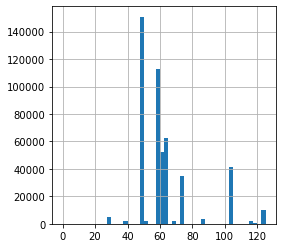

In [16]:
# Average speed by number of links (not length)
(sm.road_links['length'] / 1000 / sm.road_links['time'] * 3600).hist(bins=50, figsize=(4,4))

In [14]:
sm.road_links.sample(2)

,a,b,length,maxspeed,geometry,lanes,ref,time
index,,,,,,,,
rl_454592,6900312620,567582421,1767,58.0,"LINESTRING (7.59576 47.61204, 7.59816 47.59957)",2,K 6326,109.675862
rl_101194,5799377310,27199799,8,50.0,"LINESTRING (13.38077 52.57449, 13.38084 52.57443)",3,None,0.576000


### Alter road access/egress links

In [18]:
# Find missing connectors
missing_connectors = set(sm.zones.index) - set(sm.zone_to_road['a'])
islands = ['DE94C_7', 'DE947_2', 'DE947_4', 'DE94H_3',
           'DE94H_4', 'DE94A_2', 'outer_2', 'DEF07_3']
missing_connectors - set(islands)

{'DE80J_5', 'DE937_4'}

In [21]:
# Add missing connectors
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids.loc[missing_connectors - set(islands)],
    sm.road_nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=1,
    coordinates_unit=sm.coordinates_unit)
sm.zone_to_road = sm.zone_to_road.append(
    ntlegs[set(sm.zone_to_road.columns).intersection(ntlegs.columns)]
).reset_index(drop=True)

In [29]:
# Drop island road connections (except Sylt) and connect
# them to a virtual single road node
sm.zone_to_road = sm.zone_to_road.loc[~(sm.zone_to_road['a'].isin(islands))
                                      & ~(sm.zone_to_road['b'].isin(islands))]
for i in islands:
    road_node = gpd.GeoDataFrame({'FID': [i]},
                                 index=[i+'_n'],
                                 geometry=[sm.centroids.loc[i, 'geometry']],
                                 crs=sm.epsg)
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids.loc[[i]],
        road_node,
        short_leg_speed=params['pt_access']['speed_walk'],
        long_leg_speed=params['pt_access']['speed_bicycle'],
        threshold=params['pt_access']['catchment_radius_walk'],
        n_neighbors=1,
        coordinates_unit=sm.coordinates_unit)
    sm.zone_to_road = sm.zone_to_road.append(
        ntlegs[set(sm.zone_to_road.columns).intersection(ntlegs.columns)]
    ).reset_index(drop=True)
    sm.road_nodes = sm.road_nodes.append(road_node)

In [36]:
# Every zone must be connected
assert len(sm.zone_to_road.loc[sm.zone_to_road['direction']=='access','a'
                              ].unique()) == len(sm.zones.index)

In [37]:
# Assign a time
sm.zone_to_road['time'] = params['access-egress_links']['time_road']

## Apply road pathfinder in order to generate LoS table

In [38]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

The volumes file is not (yet) available


In [56]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

self.volumes does not exist. od generated with self.zones
 'all_or_nothing'=True is deprecated. use method = 'aon' instead


In [49]:
sm.car_los.sample()

,origin,destination,time,path,gtime
2383431,DE721_4,DE228_4,16688.566338,"[DE721_4, 4562338955, 969012336, 969012305, 20...",16688.566338


In [57]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['origin']!=sm.car_los['destination']]
sm.car_los.shape

(4948400, 5)

In [61]:
# Drop non-existent island connections
sm.car_los = sm.car_los.drop(sm.car_los.loc[(sm.car_los['time']==np.inf)].index)
len(sm.car_los)

4910656

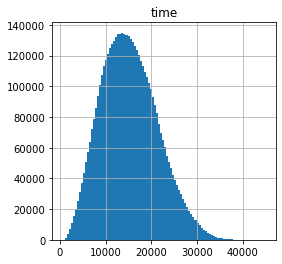

In [62]:
if manual: sm.car_los.hist(column='time', bins=100, figsize=(4,4))

## Add various attributes to LoS table

In [78]:
sm.analysis_car_los()

In [86]:
# Disaggregate into in-vehicle time and access/egress
sm.car_los['access_time'] = sm.car_los['origin'].map(
    sm.zone_to_road.drop_duplicates('a').set_index('a')['time'])
sm.car_los['in_vehicle_time'] = sm.car_los['time'] - sm.car_los['access_time']

In [79]:
# Add distances car
if not 'length' in sm.road_links.columns:
    sm.road_links['length'] = skims.distance_from_geometry(sm.road_links['geometry']).astype(int)
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [87]:
# Add route_type = 'car' in car_los
sm.car_los['route_type'] = 'car'
sm.car_los['route_types'] = [(t,) for t in sm.car_los['route_type']]

In [68]:
#sm.car_los['ntransfers'] = 0

In [80]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade (DE939) - Stuttgart (DE111): 7h45m, 687km
# Stendal (DEE0D) - Stuttgart (DE111): 6h11m, 574km
# Stendal (DEE0D) - Stade (DE939): 3h22m, 231km
od = ['DE300_0', 'DE939_6', 'DE111_0', 'DEE0D_2']
for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                             (sm.car_los['destination'].isin(od))].iterrows():
    print(row['origin'] + ' - ' + row['destination'] + ': '
          + str(np.round(row['time']/3600,1)) + ', '
          + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE111_0 - DE300_0: 5.6, 631km
DE111_0 - DE939_6: 6.9, 685km
DE111_0 - DEE0D_2: 6.1, 630km
DE300_0 - DE111_0: 5.6, 631km
DE300_0 - DE939_6: 4.1, 339km
DE300_0 - DEE0D_2: 2.6, 199km
DE939_6 - DE111_0: 6.9, 685km
DE939_6 - DE300_0: 4.1, 353km
DE939_6 - DEE0D_2: 4.7, 355km
DEE0D_2 - DE111_0: 6.1, 630km
DEE0D_2 - DE300_0: 2.7, 200km
DEE0D_2 - DE939_6: 4.7, 354km


## Save model

In [81]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [82]:
sm.car_los.columns

Index(['origin', 'destination', 'time', 'link_path', 'access_time',
       'in_vehicle_time', 'length', 'route_type', 'route_types'],
      dtype='object')

In [89]:
assert sm.car_los.isna().any(axis=1).max() == 0

In [90]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [91]:
sm.to_json(model_path + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 13/13 [13:40<00:00, 63.12s/it]


In [40]:
# Also save road links with imputated maxspeeds
sm.road_links["time"] = sm.road_links["time"].astype(int)
sm.to_json(input_path + 'de_road_network', only_attributes=
           ['road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [01:38<00:00,  2.88s/it]
